In [1]:
'''# downloading dataset from https://archive.materialscloud.org/record/2020.110

!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'# downloading dataset from https://archive.materialscloud.org/record/2020.110\n\n!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
import torch
from torch import nn
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *

In [3]:
HARTREE_TO_EV = 27.211386245988
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_subset = '0:1000'
test_subset = '1000:1500'
DEVICE = 'cuda'

In [4]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species, split_by_central_specie = False)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species, split_by_central_specie = False)

scaler = InitialScaler(mode='signal integral', individually=True)
scaler.fit(train_coefficients[0:500])

train_coefficients = scaler.transform(train_coefficients)
test_coefficients = scaler.transform(test_coefficients)

print(train_coefficients.shape)
print(test_coefficients.shape)

100%|██████████| 5/5 [00:00<00:00, 68.11it/s]

(5000, 10, 6, 11)
(2500, 10, 6, 11)


In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

In [6]:
def convert_to_torch(coefficients, device):
    result = {}
    for lambd in range(coefficients.shape[2]):
        result[lambd] = torch.FloatTensor(coefficients[:, :, lambd, : 2 * lambd + 1]).to(device)        
    return result

train_coefficients = convert_to_torch(train_coefficients, DEVICE)
test_coefficients = convert_to_torch(test_coefficients, DEVICE)

for key in train_coefficients.keys():
    print(train_coefficients[key].shape)

torch.Size([5000, 10, 1])
torch.Size([5000, 10, 3])
torch.Size([5000, 10, 5])
torch.Size([5000, 10, 7])
torch.Size([5000, 10, 9])
torch.Size([5000, 10, 11])


In [7]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

class Model(torch.nn.Module):
    def __init__(self, input_lambda_max):
        super(Model, self).__init__()
        clebsch = nice.clebsch_gordan.ClebschGordan(input_lambda_max)
        self.clebsch_combining = ClebschCombining(clebsch.precomputed_, 0)
        self.sequential = nn.Sequential(nn.Linear(600, 100), nn.Tanh(), nn.Linear(100, 1))
        
    def forward(self, X):
        X = self.clebsch_combining(X, X)[0].squeeze()        
        return {'predictions' : self.sequential(X)}

In [8]:
model = Model(LAMBDA_MAX)
result = model(train_coefficients)
print(type(result))
print(result['predictions'].shape)

<class 'dict'>
torch.Size([5000, 1])


In [9]:
models = {}
for key in all_species:
    models[str(key)] = Model(LAMBDA_MAX)
    

In [10]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())
train_structural_indices = get_structural_indices(train_structures)
test_structural_indices = get_structural_indices(test_structures)


train_central_species = get_central_species(train_structures)
test_central_species = get_central_species(test_structures)

train_atomic = copy.deepcopy(train_coefficients)
train_atomic['central_species'] = train_central_species

test_atomic = copy.deepcopy(test_coefficients)
test_atomic['central_species'] = test_central_species

train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}

BATCH_SIZE = 500
for epoch_num in range(1000):
    train_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(train_atomic, train_struc,
                                                  train_structural_indices, BATCH_SIZE):
        central_species_now = atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
        
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    train_predictions = np.concatenate(train_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("train mae: ", get_mae(train_predictions, train_energies.data.cpu().numpy()))
        print("train rmse: ", get_rmse(train_predictions, train_energies.data.cpu().numpy()))
        
    test_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(test_atomic, test_struc,
                                                   test_structural_indices, BATCH_SIZE):
        central_species_now =  atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    if epoch_num % 100 == 0:
        print("test mae: ", get_mae(test_predictions, test_energies.data.cpu().numpy()))
        print("test rmse: ", get_rmse(test_predictions, test_energies.data.cpu().numpy()))
    

train mae:  2.053918
train rmse:  3.0281086
test mae:  2.1994796
test rmse:  3.460166
train mae:  0.5847837
train rmse:  0.8605154
test mae:  0.6614871
test rmse:  1.1908453
train mae:  0.4644978
train rmse:  0.6714235
test mae:  0.5543523
test rmse:  1.0004503
train mae:  0.41906995
train rmse:  0.5909478
test mae:  0.50308204
test rmse:  0.9036707
train mae:  0.38852844
train rmse:  0.53691465
test mae:  0.47108242
test rmse:  0.8360281
train mae:  0.36306983
train rmse:  0.49516112
test mae:  0.44568366
test rmse:  0.78390515
train mae:  0.34316775
train rmse:  0.4636498
test mae:  0.42634398
test rmse:  0.74396056
train mae:  0.32839045
train rmse:  0.44118676
test mae:  0.41316906
test rmse:  0.7146122
train mae:  0.31763497
train rmse:  0.4253206
test mae:  0.40389985
test rmse:  0.6934823
train mae:  0.30984232
train rmse:  0.41371515
test mae:  0.39741507
test rmse:  0.6784019


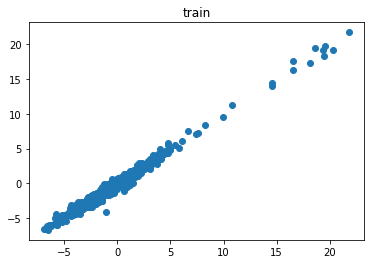

train rmse 0.4048437
train mae:  0.30401772


In [11]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 0.66786796
test mae:  0.39205006


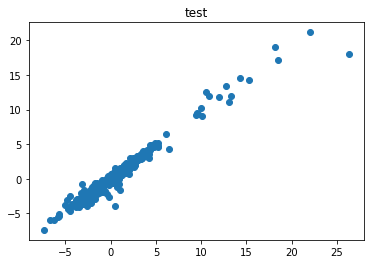

In [12]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

In [30]:
for key in coef_now.keys():
    print(key, coef_now[key].shape)
    

predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
print(predictions.requires_grad)
print(coef_now[0].requires_grad)
coef_now[0].requires_grad = True

print(predictions.shape)
derivatives = torch.autograd.grad(outputs = predictions, inputs = coef_now[0], 
                                  grad_outputs = torch.ones(predictions.shape, device = DEVICE))
print(derivatives[0].shape)

0 torch.Size([2500, 10, 1])
1 torch.Size([2500, 10, 3])
2 torch.Size([2500, 10, 5])
3 torch.Size([2500, 10, 7])
4 torch.Size([2500, 10, 9])
5 torch.Size([2500, 10, 11])
True
True
torch.Size([500])
torch.Size([2500, 10, 1])


In [31]:
a = torch.randn(5)
print(a)

tensor([-0.4884, -0.7990, -0.8001,  0.1582,  2.4297])


In [34]:
print(torch.max(a).item())

2.429661750793457
